## 0.1 imports

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore, Style
import datetime as dt
from collections import defaultdict
from tqdm import tqdm
from pathlib import Path
from typing import List, Literal, Tuple
from google.cloud import bigquery, storage

In [2]:
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    FunctionTransformer,
)
from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import make_column_transformer, ColumnTransformer

from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchinfo import summary

# 1. Load the raw data

#### **Collected data**

#### 📌 Tempelhofer Feld, Berlin, Germany

<iframe src="https://www.google.com/maps/embed?pb=!1m18!1m12!1m3!1d26842.24808091901!2d13.400488957085193!3d52.477045271245125!2m3!1f0!2f0!3f0!3m2!1i1024!2i768!4f13.1!3m3!1m2!1s0x47a84fe8f7d899eb%3A0x88898e99acbb718b!2sTempelhofer%20Feld!5e0!3m2!1sen!2sde!4v1736167638260!5m2!1sen!2sde" width="1200" height="450" style="border:0;" allowfullscreen="" loading="lazy" referrerpolicy="no-referrer-when-downgrade"></iframe>


### ☀️ 1. Historical photovoltaic production data
* 42 years (1980 - 2022)
* hourly resolution
* synthetic data derived from measured irradiance data
* ~ 400 000 data points
* source: [Renewables.ninja](https://www.renewables.ninja/about "Renewables.ninja")

### 🌡️ 2. Historical weather forecast data
* 6 1/2 years (Oct 2017 - Mar 2024)
* 4 model recalculation cycles available for each day (updated at: 00:00 UTC, 06:00 UTC, 12:00 UTC, 18:00 UTC)
* Each 16 days forecast in hourly resolution
* ~ 3.3 M rows - 24 Features
* source: [OpenWeather](https://openweathermap.org/api/history-forecast-bulk "History-forecast-bulk") (40 €)


In [4]:
pv_data = pd.read_csv("../data/1980-2022_pv.csv", memory_map=True)
forecast_data = pd.read_csv(
    "../data/openweather_history_bulk_forecast_tempelhof.csv", memory_map=True
)

# 2. Check the data

## 2.1 Photovolatic data

In [5]:
pv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376944 entries, 0 to 376943
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0.1        376944 non-null  int64  
 1   Unnamed: 0          376944 non-null  int64  
 2   local_time          376944 non-null  object 
 3   electricity         376944 non-null  float64
 4   irradiance_direct   376944 non-null  float64
 5   irradiance_diffuse  376944 non-null  float64
 6   temperature         376944 non-null  float64
 7   source              376944 non-null  object 
dtypes: float64(4), int64(2), object(2)
memory usage: 23.0+ MB


In [6]:
pv_data.isna().sum()

Unnamed: 0.1          0
Unnamed: 0            0
local_time            0
electricity           0
irradiance_direct     0
irradiance_diffuse    0
temperature           0
source                0
dtype: int64

In [7]:
pv_data.isnull().sum()

Unnamed: 0.1          0
Unnamed: 0            0
local_time            0
electricity           0
irradiance_direct     0
irradiance_diffuse    0
temperature           0
source                0
dtype: int64

In [8]:
pv_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0.1,376944.0,4.382576e+03,2.530581e+03,0.000000e+00,2.191000e+03,4.383000e+03,6.574000e+03,8.783000e+03
Unnamed: 0,376944.0,9.940302e+11,3.917322e+11,3.155328e+11,6.547815e+11,9.940302e+11,1.333279e+12,1.672528e+12
electricity,376944.0,1.345303e-01,2.148500e-01,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e-01,9.000000e-01
irradiance_direct,376944.0,1.068965e-01,2.120717e-01,0.000000e+00,0.000000e+00,0.000000e+00,7.700000e-02,1.016000e+00
irradiance_diffuse,376944.0,5.566084e-02,7.542225e-02,0.000000e+00,0.000000e+00,4.000000e-03,1.020000e-01,3.580000e-01
temperature,376944.0,9.219034e+00,9.013729e+00,-2.745800e+01,2.217000e+00,8.863000e+00,1.591600e+01,3.875600e+01


### 2.1.1 check for time gaps in data

In [9]:
# number of rows with unique values in our data
local_time_series = pd.to_datetime(pv_data["local_time"], utc=True)

unique_timestamps_pv_dataset = local_time_series.nunique()
unique_timestamps_pv_dataset

376944

In [10]:
# number of rows with unique values of a synthetic data with the same range
min_date = local_time_series.min()
max_date = local_time_series.max()
unique_timestamps_pv_dataset_theoretical = pd.date_range(
    start=min_date, end=max_date, freq=dt.timedelta(hours=1.0)
).nunique()
unique_timestamps_pv_dataset_theoretical

376944

In [11]:
try:
    assert unique_timestamps_pv_dataset == unique_timestamps_pv_dataset_theoretical
    print("all good! there are no gaps in your dataset...")
except AssertionError:
    print("there are gaps in your dataset")

all good! there are no gaps in your dataset...


# 3. Preprocess the data

## 3.1 Photovolatic data

In [12]:
pv_data.head()

,Unnamed: 0.1,Unnamed: 0,local_time,electricity,irradiance_direct,irradiance_diffuse,temperature,source
0,0,315532800000,1980-01-01 01:00:00+01:00,0.0,0.0,0.0,-1.296,data/pv_data/1980_pv.csv
1,1,315536400000,1980-01-01 02:00:00+01:00,0.0,0.0,0.0,-1.216,data/pv_data/1980_pv.csv
2,2,315540000000,1980-01-01 03:00:00+01:00,0.0,0.0,0.0,-1.005,data/pv_data/1980_pv.csv
3,3,315543600000,1980-01-01 04:00:00+01:00,0.0,0.0,0.0,-1.063,data/pv_data/1980_pv.csv
4,4,315547200000,1980-01-01 05:00:00+01:00,0.0,0.0,0.0,-1.227,data/pv_data/1980_pv.csv


In [13]:
def time_encoding(X: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """
    Convert local time into cyclic features to feed significant signal
    in ML / DL algorithm

    Args:
        X (pd.DataFrame): datafrane to transform

    Returns:
        DataFrame with 4 addtional features per time column
    """
    X = X.copy()

    local_time = pd.to_datetime(X.pop(column_name), utc=True)
    timestamp_s = local_time.map(pd.Timestamp.timestamp)

    day = 24 * 60 * 60
    year = (365.2425) * day
    X["day_sin"] = np.sin(timestamp_s * (2 * np.pi / day))
    X["day_cos"] = np.cos(timestamp_s * (2 * np.pi / day))
    X["year_sin"] = np.sin(timestamp_s * (2 * np.pi / year))
    X["year_cos"] = np.cos(timestamp_s * (2 * np.pi / year))

    return X.iloc[:, -4:]


time_encoder = FunctionTransformer(time_encoding, kw_args={"column_name": "local_time"})

pv_transformer = ColumnTransformer(
    [
        ("Time Encoder", time_encoder, ["local_time"]),
        ("Passthrough", "passthrough", ["local_time", "electricity"]),
    ],
    remainder="drop",
).set_output(transform="pandas")

preprocess_pv = Pipeline([("Time Features", pv_transformer)])
pv_processed = preprocess_pv.fit_transform(pv_data)

pv_processed.columns = [column.split("__")[1] for column in pv_processed.columns]
pv_processed

/home/jerome-roeser/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


,day_sin,day_cos,year_sin,year_cos,local_time,electricity
0,3.844949e-13,1.000000,-0.007311,0.999973,1980-01-01 01:00:00+01:00,0.0
1,2.588190e-01,0.965926,-0.006594,0.999978,1980-01-01 02:00:00+01:00,0.0
2,5.000000e-01,0.866025,-0.005878,0.999983,1980-01-01 03:00:00+01:00,0.0
3,7.071068e-01,0.707107,-0.005161,0.999987,1980-01-01 04:00:00+01:00,0.0
4,8.660254e-01,0.500000,-0.004444,0.999990,1980-01-01 05:00:00+01:00,0.0
...,...,...,...,...,...,...
376939,-9.659258e-01,0.258819,-0.001047,0.999999,2022-12-31 20:00:00+01:00,0.0
376940,-8.660254e-01,0.500000,-0.000330,1.000000,2022-12-31 21:00:00+01:00,0.0
376941,-7.071068e-01,0.707107,0.000387,1.000000,2022-12-31 22:00:00+01:00,0.0
376942,-5.000000e-01,0.866025,0.001104,0.999999,2022-12-31 23:00:00+01:00,0.0


<AxesSubplot:xlabel='variable', ylabel='value'>

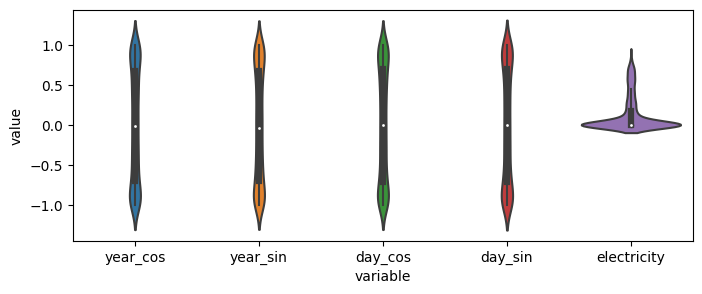

In [14]:
num_cols_pv = pv_processed.select_dtypes(include=np.number).columns
melted_pv_df = pd.melt(pv_processed[num_cols_pv])

plt.figure(figsize=(8, 3))
sns.violinplot(data=melted_pv_df.sample(10_000), x="variable", y="value")

In [15]:
column_indices = {name: i for i, name in enumerate(pv_processed.columns)}
column_indices

{'day_sin': 0,
 'day_cos': 1,
 'year_sin': 2,
 'year_cos': 3,
 'local_time': 4,
 'electricity': 5}

## 3.2 Weather forecast data

In [16]:
forecast_data.head()

,forecast dt unixtime,forecast dt iso,slice dt unixtime,slice dt iso,lat,lon,temperature,dew_point,pressure,ground_pressure,...,rain,snow,ice,fr_rain,convective,snow_depth,accumulated,hours,rate,probability
0,1507334400,2017-10-07 00:00:00 +0000 UTC,1507334400,2017-10-07 00:00:00 +0000 UTC,52.47,13.4,9.07,7.75,1015.81,1010.16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.00
1,1507334400,2017-10-07 00:00:00 +0000 UTC,1507338000,2017-10-07 01:00:00 +0000 UTC,52.47,13.4,9.49,7.62,1015.75,1010.19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.04
2,1507334400,2017-10-07 00:00:00 +0000 UTC,1507341600,2017-10-07 02:00:00 +0000 UTC,52.47,13.4,9.64,7.68,1015.80,1010.29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.03
3,1507334400,2017-10-07 00:00:00 +0000 UTC,1507345200,2017-10-07 03:00:00 +0000 UTC,52.47,13.4,9.63,7.85,1015.91,1010.40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.00
4,1507334400,2017-10-07 00:00:00 +0000 UTC,1507348800,2017-10-07 04:00:00 +0000 UTC,52.47,13.4,9.61,8.02,1016.03,1010.52,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000008,0.00


In [17]:
def compress(df: pd.DataFrame, **kwargs) -> pd.DataFrame:
    """
    Reduces size of dataframe by downcasting numerical columns
    """
    input_size = df.memory_usage(index=True).sum() / 1024
    print("dataframe size: ", round(input_size, 2), "kB")

    in_size = df.memory_usage(index=True).sum()
    for type in ["float", "integer"]:
        l_cols = list(df.select_dtypes(include=type))
        for col in l_cols:
            df[col] = pd.to_numeric(df[col], downcast=type)
    out_size = df.memory_usage(index=True).sum()
    ratio = (1 - round(out_size / in_size, 2)) * 100

    print(f"optimized size by {ratio:.2f} %")
    print(f"new dataframe size: {(out_size / 1024):.2f} kB")

    return df


def clean_forecast_data(forecast_df: pd.DataFrame) -> pd.DataFrame:
    """
    Initial has 3.3 M entries (everyday: 4 forecasts of 16 days ahead)
    Cleaning it to: - 1 forecast perday (at 12:00)
                    - 48 hours a day
                    - right now hardcoded to match last forecast day with
                     last day of PV data
    """
    df = compress(forecast_df)
    df = df.drop(columns=["lat", "lon", "forecast dt iso", "slice dt iso"])

    df.rename(
        columns={
            "forecast dt unixtime": "utc_time",
            "slice dt unixtime": "prediction_utc_time",
        },
        inplace=True,
    )

    # df['utc_time'] = df['utc_time'].str.replace('+0000 UTC', '')
    # df['prediction_utc_time'] = df['prediction_utc_time'].str.replace('+0000 UTC', '')

    df["utc_time"] = pd.to_datetime(df["utc_time"], unit="s", utc=True)
    df["prediction_utc_time"] = pd.to_datetime(
        df["prediction_utc_time"], unit="s", utc=True
    )

    # # get only 1 forecast per day
    df = df[df["utc_time"].dt.hour == 12]

    unique_dates = df["utc_time"].unique()

    # reduce to 24h of weather forecast (from 00:00 to 23:00 each day)
    df_revised = []
    for date in unique_dates:
        data = df[(df["utc_time"] == date)].iloc[12:36]
        df_revised.append(data)

    df_revised_ordered = pd.concat(df_revised, ignore_index=True)

    # # hard code the end date to match wiht PV data
    # processed_df = df_revised_ordered[df_revised_ordered['prediction_utc_time'] <= '2022-12-31 23:00:00']

    return df_revised_ordered


forecast_clean = clean_forecast_data(forecast_data)
forecast_clean

dataframe size:  617298.69 kB
optimized size by 46.00 %
new dataframe size: 334370.18 kB


,utc_time,prediction_utc_time,temperature,dew_point,pressure,ground_pressure,humidity,clouds,wind_speed,wind_deg,rain,snow,ice,fr_rain,convective,snow_depth,accumulated,hours,rate,probability
0,2017-10-07 12:00:00+00:00,2017-10-08 00:00:00+00:00,11.32,8.95,1004.539978,999.000000,85.199997,100.0,7.20,256.970001,0.33,0.0,0.0,0.0,0.000,0.0,0.33,1.0,0.000092,1.00
1,2017-10-07 12:00:00+00:00,2017-10-08 01:00:00+00:00,11.61,9.33,1004.570007,998.989990,85.790001,100.0,6.63,264.929993,0.24,0.0,0.0,0.0,0.000,0.0,0.24,1.0,0.000067,0.93
2,2017-10-07 12:00:00+00:00,2017-10-08 02:00:00+00:00,11.88,9.72,1004.760010,999.140015,86.470001,100.0,5.95,272.799988,0.19,0.0,0.0,0.0,0.000,0.0,0.19,1.0,0.000053,0.83
3,2017-10-07 12:00:00+00:00,2017-10-08 03:00:00+00:00,11.96,9.95,1005.140015,999.469971,87.400002,99.0,5.53,278.609985,0.15,0.0,0.0,0.0,0.042,0.0,0.15,1.0,0.000042,0.73
4,2017-10-07 12:00:00+00:00,2017-10-08 04:00:00+00:00,11.73,9.91,1005.750000,1000.030029,88.480003,98.0,5.63,281.290009,0.11,0.0,0.0,0.0,0.042,0.0,0.11,1.0,0.000031,0.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56371,2024-03-12 12:00:00+00:00,2024-03-13 19:00:00+00:00,10.53,3.09,1016.969971,1011.140015,59.790001,90.0,2.42,216.630005,0.00,0.0,0.0,0.0,0.042,0.0,0.00,1.0,0.000000,0.00
56372,2024-03-12 12:00:00+00:00,2024-03-13 20:00:00+00:00,10.18,3.04,1017.039978,1011.219971,61.009998,87.0,2.39,206.800003,0.00,0.0,0.0,0.0,0.042,0.0,0.00,1.0,0.000000,0.00
56373,2024-03-12 12:00:00+00:00,2024-03-13 21:00:00+00:00,9.93,3.27,1017.039978,1011.210022,63.400002,86.0,2.41,201.100006,0.00,0.0,0.0,0.0,0.042,0.0,0.00,1.0,0.000000,0.00
56374,2024-03-12 12:00:00+00:00,2024-03-13 22:00:00+00:00,9.74,4.06,1016.960022,1011.130005,68.389999,87.0,2.45,204.210007,0.00,0.0,0.0,0.0,0.042,0.0,0.00,1.0,0.000000,0.04


In [18]:
# stick day_ahead (label) and day_before (feature) electricity data to the forecast data
pv_data["local_time"] = pd.to_datetime(pv_data["local_time"], utc=True)

# the electricity feature is the electricity produced 2 days before
# the production amount we want to predict
forecast_clean["electricity_feature_utc_time"] = forecast_clean[
    "prediction_utc_time"
] - np.timedelta64(7,"D")

merged_forecast_pv = pd.merge(
    pv_data[["local_time", "electricity"]],
    forecast_clean,
    left_on="local_time",
    right_on="electricity_feature_utc_time",
    how="inner",
)
merged_forecast_pv = merged_forecast_pv.rename(
    columns={"electricity": "electricity_feature"}
)

merged_forecast_pv = pd.merge(
    pv_data[["local_time", "electricity"]],
    merged_forecast_pv,
    left_on="local_time",
    right_on="prediction_utc_time",
    how="inner",
)
merged_forecast_pv

,local_time_x,electricity,local_time_y,electricity_feature,utc_time,prediction_utc_time,temperature,dew_point,pressure,ground_pressure,...,snow,ice,fr_rain,convective,snow_depth,accumulated,hours,rate,probability,electricity_feature_utc_time
0,2017-10-08 00:00:00+00:00,0.0,2017-10-01 00:00:00+00:00,0.0,2017-10-07 12:00:00+00:00,2017-10-08 00:00:00+00:00,11.32,8.95,1004.539978,999.000000,...,0.0,0.0,0.0,0.000,0.0,0.33,1.0,0.000092,1.00,2017-10-01 00:00:00+00:00
1,2017-10-08 01:00:00+00:00,0.0,2017-10-01 01:00:00+00:00,0.0,2017-10-07 12:00:00+00:00,2017-10-08 01:00:00+00:00,11.61,9.33,1004.570007,998.989990,...,0.0,0.0,0.0,0.000,0.0,0.24,1.0,0.000067,0.93,2017-10-01 01:00:00+00:00
2,2017-10-08 02:00:00+00:00,0.0,2017-10-01 02:00:00+00:00,0.0,2017-10-07 12:00:00+00:00,2017-10-08 02:00:00+00:00,11.88,9.72,1004.760010,999.140015,...,0.0,0.0,0.0,0.000,0.0,0.19,1.0,0.000053,0.83,2017-10-01 02:00:00+00:00
3,2017-10-08 03:00:00+00:00,0.0,2017-10-01 03:00:00+00:00,0.0,2017-10-07 12:00:00+00:00,2017-10-08 03:00:00+00:00,11.96,9.95,1005.140015,999.469971,...,0.0,0.0,0.0,0.042,0.0,0.15,1.0,0.000042,0.73,2017-10-01 03:00:00+00:00
4,2017-10-08 04:00:00+00:00,0.0,2017-10-01 04:00:00+00:00,0.0,2017-10-07 12:00:00+00:00,2017-10-08 04:00:00+00:00,11.73,9.91,1005.750000,1000.030029,...,0.0,0.0,0.0,0.042,0.0,0.11,1.0,0.000031,0.67,2017-10-01 04:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45859,2022-12-31 19:00:00+00:00,0.0,2022-12-24 19:00:00+00:00,0.0,2022-12-30 12:00:00+00:00,2022-12-31 19:00:00+00:00,14.22,9.86,1011.669983,1005.960022,...,0.0,0.0,0.0,0.062,0.0,0.00,1.0,0.000000,0.01,2022-12-24 19:00:00+00:00
45860,2022-12-31 20:00:00+00:00,0.0,2022-12-24 20:00:00+00:00,0.0,2022-12-30 12:00:00+00:00,2022-12-31 20:00:00+00:00,14.13,9.57,1011.770020,1006.059998,...,0.0,0.0,0.0,0.062,0.0,0.00,1.0,0.000000,0.01,2022-12-24 20:00:00+00:00
45861,2022-12-31 21:00:00+00:00,0.0,2022-12-24 21:00:00+00:00,0.0,2022-12-30 12:00:00+00:00,2022-12-31 21:00:00+00:00,14.09,9.18,1011.909973,1006.210022,...,0.0,0.0,0.0,0.062,0.0,0.00,1.0,0.000000,0.00,2022-12-24 21:00:00+00:00
45862,2022-12-31 22:00:00+00:00,0.0,2022-12-24 22:00:00+00:00,0.0,2022-12-30 12:00:00+00:00,2022-12-31 22:00:00+00:00,14.07,8.75,1012.140015,1006.440002,...,0.0,0.0,0.0,0.062,0.0,0.00,1.0,0.000000,0.00,2022-12-24 22:00:00+00:00


In [19]:
def time_encoding(X: pd.DataFrame) -> pd.DataFrame:
    """
    Convert local time into cyclic features to feed significant signal
    in ML / DL algorithm

    Args:
    X: datafrane to transform

    Output:
    DataFrame with 4 addtional features per time column
    """
    X = X.copy()

    date_time = pd.to_datetime(X.pop("prediction_utc_time"), utc=True)
    timestamp_s = date_time.map(pd.Timestamp.timestamp)

    day = 24 * 60 * 60
    year = (365.2425) * day
    X["forecast_day_sin"] = np.sin(timestamp_s * (2 * np.pi / day))
    X["forecast_day_cos"] = np.cos(timestamp_s * (2 * np.pi / day))
    X["forecast_year_sin"] = np.sin(timestamp_s * (2 * np.pi / year))
    X["forecast_year_cos"] = np.cos(timestamp_s * (2 * np.pi / year))

    return X.iloc[:, -4:]


def wind_encoding(X: pd.DataFrame) -> pd.DataFrame:
    """
    Convert local time into cyclic features to feed significant signal
    in ML / DL algorithm

    Args:
    X: datafrane to transform

    Output:
    DataFrame with 4 addtional features per time column
    """
    X = X.copy()

    # Process wind fratures
    wind_speed = X.pop("wind_speed")

    # Convert to radians.
    wind_rad = X.pop("wind_deg") * np.pi / 180

    # Calculate the wind x and y components
    X["Wx"] = wind_speed * np.cos(wind_rad)
    X["Wy"] = wind_speed * np.sin(wind_rad)

    # Standardize the components
    X["Wx"] = (X["Wx"] - X["Wx"].mean()) / X["Wx"].std()
    X["Wy"] = (X["Wy"] - X["Wy"].mean()) / X["Wy"].std()

    return X.iloc[:, -2:]


std_features = [
    "temperature",
    "dew_point",
    "pressure",
    "ground_pressure",
    "humidity",
]
minmax_features = [
    "clouds",
    "rain",
    "snow",
    "ice",
    "fr_rain",
    "convective",
    "snow_depth",
    "accumulated",
    "hours",
    "rate",
    "probability",
]

time_encoder = FunctionTransformer(time_encoding)
wind_encoder = FunctionTransformer(wind_encoding)

forecast_transformer = ColumnTransformer(
    [
        ("Time Encoder", time_encoder, ["prediction_utc_time"]),
        ("Wind Encoder", wind_encoder, ["wind_speed", "wind_deg"]),
        ("Std", StandardScaler(), std_features),
        ("MinMax", MinMaxScaler(), minmax_features),
        # ('Drop', 'drop', ['local_time', 'utc_time', 'prediction_utc_time']),
        ("Passthrough", "passthrough", ["utc_time", "prediction_utc_time"]),
    ],
    remainder="passthrough",
).set_output(transform="pandas")


forecast_processed = forecast_transformer.fit_transform(merged_forecast_pv)

forecast_processed.columns = [
    column.split("__")[1] for column in forecast_processed.columns
]
display(forecast_processed)
forecast_transformer

/home/jerome-roeser/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


,forecast_day_sin,forecast_day_cos,forecast_year_sin,forecast_year_cos,Wx,Wy,temperature,dew_point,pressure,ground_pressure,...,hours,rate,probability,utc_time,prediction_utc_time,local_time_x,electricity,local_time_y,electricity_feature,electricity_feature_utc_time
0,-3.967749e-12,1.000000,-0.993423,0.114502,-0.498317,-1.805897,-0.014501,0.628072,-1.201826,-1.180020,...,0.0,0.035155,1.00,2017-10-07 12:00:00+00:00,2017-10-08 00:00:00+00:00,2017-10-08 00:00:00+00:00,0.0,2017-10-01 00:00:00+00:00,0.0,2017-10-01 00:00:00+00:00
1,2.588190e-01,0.965926,-0.993341,0.115214,-0.057784,-1.680156,0.021330,0.688091,-1.198605,-1.181100,...,0.0,0.025602,0.93,2017-10-07 12:00:00+00:00,2017-10-08 01:00:00+00:00,2017-10-08 01:00:00+00:00,0.0,2017-10-01 01:00:00+00:00,0.0,2017-10-01 01:00:00+00:00
2,5.000000e-01,0.866025,-0.993258,0.115926,0.314448,-1.477663,0.054690,0.749689,-1.178222,-1.164916,...,0.0,0.020252,0.83,2017-10-07 12:00:00+00:00,2017-10-08 02:00:00+00:00,2017-10-08 02:00:00+00:00,0.0,2017-10-01 02:00:00+00:00,0.0,2017-10-01 02:00:00+00:00
3,7.071068e-01,0.707107,-0.993175,0.116638,0.542581,-1.332119,0.064575,0.786016,-1.137458,-1.129322,...,0.0,0.016049,0.73,2017-10-07 12:00:00+00:00,2017-10-08 03:00:00+00:00,2017-10-08 03:00:00+00:00,0.0,2017-10-01 03:00:00+00:00,0.0,2017-10-01 03:00:00+00:00
4,8.660254e-01,0.500000,-0.993091,0.117349,0.659075,-1.348465,0.036157,0.779698,-1.072022,-1.068905,...,0.0,0.011846,0.67,2017-10-07 12:00:00+00:00,2017-10-08 04:00:00+00:00,2017-10-08 04:00:00+00:00,0.0,2017-10-01 04:00:00+00:00,0.0,2017-10-01 04:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45859,-9.659258e-01,0.258819,-0.001047,0.999999,-2.104921,-1.258303,0.343811,0.771801,-0.436960,-0.429204,...,0.0,0.000000,0.01,2022-12-30 12:00:00+00:00,2022-12-31 19:00:00+00:00,2022-12-31 19:00:00+00:00,0.0,2022-12-24 19:00:00+00:00,0.0,2022-12-24 19:00:00+00:00
45860,-8.660254e-01,0.500000,-0.000330,1.000000,-2.255976,-1.146842,0.332691,0.725997,-0.426229,-0.418419,...,0.0,0.000000,0.01,2022-12-30 12:00:00+00:00,2022-12-31 20:00:00+00:00,2022-12-31 20:00:00+00:00,0.0,2022-12-24 20:00:00+00:00,0.0,2022-12-24 20:00:00+00:00
45861,-7.071068e-01,0.707107,0.000387,1.000000,-2.345986,-1.076340,0.327748,0.664399,-0.411215,-0.402235,...,0.0,0.000000,0.00,2022-12-30 12:00:00+00:00,2022-12-31 21:00:00+00:00,2022-12-31 21:00:00+00:00,0.0,2022-12-24 21:00:00+00:00,0.0,2022-12-24 21:00:00+00:00
45862,-5.000000e-01,0.866025,0.001104,0.999999,-2.317896,-1.092251,0.325277,0.596483,-0.386538,-0.377426,...,0.0,0.000000,0.00,2022-12-30 12:00:00+00:00,2022-12-31 22:00:00+00:00,2022-12-31 22:00:00+00:00,0.0,2022-12-24 22:00:00+00:00,0.0,2022-12-24 22:00:00+00:00


ColumnTransformer(remainder='passthrough',
                  transformers=[('Time Encoder',
                                 FunctionTransformer(func=<function time_encoding at 0x76885137b1c0>),
                                 ['prediction_utc_time']),
                                ('Wind Encoder',
                                 FunctionTransformer(func=<function wind_encoding at 0x76885137b2e0>),
                                 ['wind_speed', 'wind_deg']),
                                ('Std', StandardScaler(),
                                 ['temperature', 'dew_point', 'pressure',
                                  'ground_pressure', 'humidity']),
                                ('MinMax', MinMaxScaler(),
                                 ['clouds', 'rain', 'snow', 'ice', 'fr_rain',
                                  'convective', 'snow_depth', 'accumulated',
                                  'hours', 'rate', 'probability']),
                                ('Passthrough', 'passthrough',
                                 ['utc_time', 'prediction_utc_time'])])

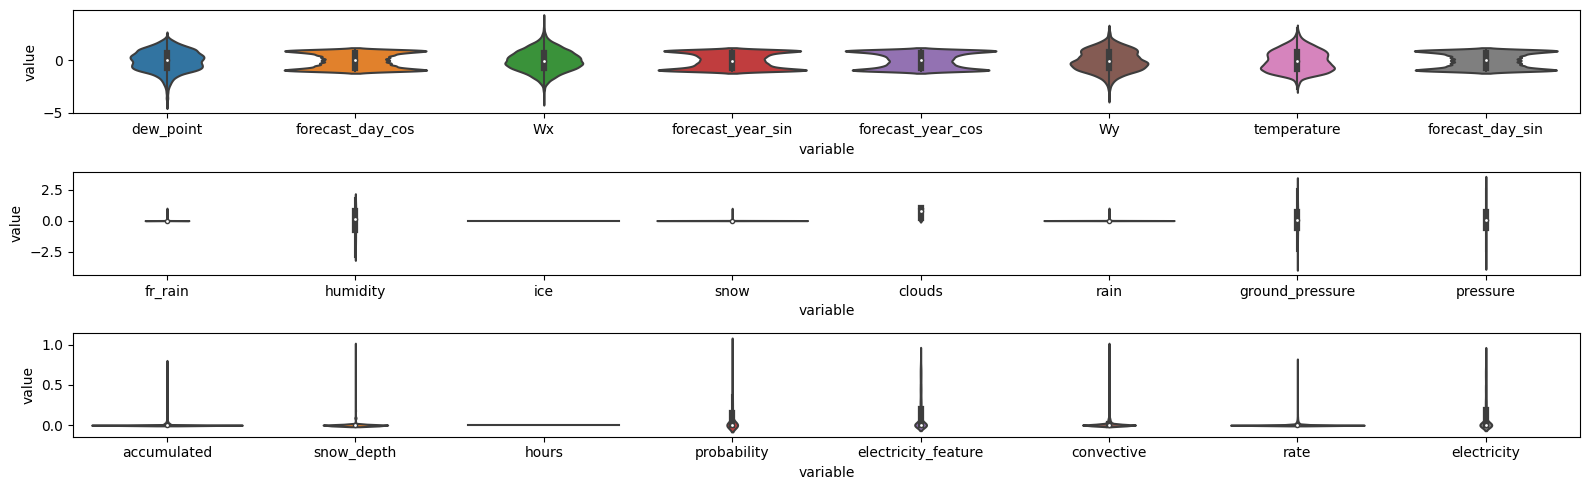

In [20]:
plt.figure(figsize=(16, 5))

num_cols_forecast = forecast_processed.select_dtypes(include=np.number).columns

plt.subplot(311)
melted_forecast_df = pd.melt(forecast_processed[num_cols_forecast].iloc[:, :8])
sns.violinplot(data=melted_forecast_df.sample(frac=0.25), x="variable", y="value")

plt.subplot(312)
melted_forecast_df = pd.melt(forecast_processed[num_cols_forecast].iloc[:, 8:16])
sns.violinplot(data=melted_forecast_df.sample(frac=0.25), x="variable", y="value")
plt.tight_layout()

plt.subplot(313)
melted_forecast_df = pd.melt(forecast_processed[num_cols_forecast].iloc[:, 16:])
sns.violinplot(data=melted_forecast_df.sample(frac=0.25), x="variable", y="value")
plt.tight_layout()

In [21]:
forecast_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45864 entries, 0 to 45863
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype              
---  ------                        --------------  -----              
 0   forecast_day_sin              45864 non-null  float64            
 1   forecast_day_cos              45864 non-null  float64            
 2   forecast_year_sin             45864 non-null  float64            
 3   forecast_year_cos             45864 non-null  float64            
 4   Wx                            45864 non-null  float32            
 5   Wy                            45864 non-null  float32            
 6   temperature                   45864 non-null  float32            
 7   dew_point                     45864 non-null  float32            
 8   pressure                      45864 non-null  float32            
 9   ground_pressure               45864 non-null  float32            
 10  humidity                      4586

# 4. Data Windowing

## 4.1 Photovoltaic Data

The goal here is to train the model on a high number of sequences. Time series data have that in particular that 

In [22]:
#### Parameters ################
#################################

INPUT_WIDTH = 48
LABEL_WIDTH = 24
SHIFT = 36


class SequenceGenerator:
    """ """

    def __init__(
        self,
        input_width: int,
        label_width: int,
        shift: int,
        number_sequences: int,
        train_df: pd.DataFrame,
        val_df: pd.DataFrame = None,
        test_df: pd.DataFrame = None,
        label_columns: List[str] = None,
    ):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.number_of_sequences = number_sequences
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, self.total_window_size)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return "\n".join(
            [
                f"Number of sequences: {self.number_of_sequences}",
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )

    def split_window(self, features):
        inputs = features[self.input_slice, :]
        labels = features[self.labels_slice, :]
        if self.label_columns is not None:
            labels = np.stack(
                [labels[:, self.column_indices[name]] for name in self.label_columns],
                axis=-1,
            )

        return inputs, labels

    def make_dataset(self, data: pd.DataFrame):
        "Create a dataset of x sequences of features and labels"
        data = np.array(data)
        last_full_sequence_start = len(data) - self.total_window_size
        inputs, labels = [], []

        for n in tqdm(range(self.number_of_sequences)):
            random_start = np.random.randint(0, last_full_sequence_start)
            input, label = self.split_window(data[random_start:])

            inputs.append(torch.tensor(input, dtype=torch.float32))
            labels.append(torch.tensor(label, dtype=torch.float32))

        inputs = torch.cat(inputs).view(self.number_of_sequences, self.input_width, -1)
        labels = torch.cat(labels).view(self.number_of_sequences, self.label_width, -1)
        return TensorDataset(inputs, labels)

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, "_example", None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result


seq_pv = SequenceGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=SHIFT,
    number_sequences=10_000,
    train_df=pv_processed,
    label_columns=["electricity"],
)

seq_pv

Number of sequences: 10000
Total window size: 84
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83]
Label column name(s): ['electricity']

## 4.2 Forecast Data

In [23]:
class SequenceForecastDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        number_days_forecast: int = 1,
        label_columns: List[str] = None,
    ):
        self.df = df.copy().astype("float32")
        self.forecast_hours = number_days_forecast * 24
        self.number_of_sequences = len(self.df) // self.forecast_hours

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(self.df.columns)}
        self.feature_columns = [
            col for col in self.df.columns if col not in self.label_columns
        ]

    def __len__(self):
        return self.number_of_sequences

    def __getitem__(self, index):
        inputs = self.df[self.feature_columns].values
        if self.label_columns is not None:
            labels = self.df[[name for name in self.label_columns]].values
        else:
            labels = self.df["electricity"].values
        return inputs.reshape(self.number_of_sequences, self.forecast_hours, -1)[
            index
        ], labels.reshape(self.number_of_sequences, self.forecast_hours, -1)[index]

    def __repr__(self):
        return "\n".join(
            [
                f"Number of sequences: {self.number_of_sequences}",
                f"Label column name(s): {self.label_columns}",
            ]
        )

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, "_example", None)
        if result is None:
            # No example batch was found, so get a random one from the dataset
            random_idx = np.random.randint(0, self.number_of_sequences)
            result = self[random_idx]
            # And cache it for next time
            self._example = result
        return result


seq_forecast = SequenceForecastDataset(
    forecast_processed.select_dtypes(include=np.number), label_columns=["electricity"]
)
seq_forecast

Number of sequences: 1911
Label column name(s): ['electricity']

# 5. Deep Learning

## 5.1 Split the data

In [24]:
# Split the PV data

column_indices = {name: i for i, name in enumerate(pv_processed.columns)}

n = len(pv_processed)
train_df_pv = pv_processed[0 : int(n * 0.7)]
val_df_pv = pv_processed[int(n * 0.7) : int(n * 0.9)]
test_df_pv = pv_processed[int(n * 0.9) :]

In [25]:
# Split the Forecast data
# Careful: split must be done for 24h data

column_indices = {name: i for i, name in enumerate(forecast_processed.columns)}

n = len(forecast_processed)
train_df_forecast = forecast_processed[0 : int(n * 0.7 / 24) * 24]
val_df_forecast = forecast_processed[int(n * 0.7 / 24) * 24 : int(n * 0.9 / 24) * 24]
test_df_forecast = forecast_processed[int(n * 0.9 / 24) * 24 :]

## 5.2 Baseline metrics

### 5.2.1 Compute regression metrics function

In [26]:
def compute_regression_metrics(model, dataloader):
    y_preds = []
    labels = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model.forward(inputs)
            y_preds.append(outputs.cpu())
            labels.append(targets.cpu())

    y_preds = torch.cat(y_preds)
    labels = torch.cat(labels)

    # Compute metrics
    mse = torch.mean((y_preds - labels) ** 2)
    rmse = mse**0.5
    mae = torch.mean(abs(y_preds - labels))
    r2 = 1 - torch.sum((y_preds - labels) ** 2) / torch.sum(
        y_preds - torch.mean(labels) ** 2
    )

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2}

### 5.2.2 Photovoltaic data

In [27]:
sequences_pv = SequenceGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=SHIFT,
    number_sequences=10_000,
    train_df=train_df_pv[num_cols_pv],
    val_df=val_df_pv[num_cols_pv],
    test_df=test_df_pv[num_cols_pv],
    label_columns=["electricity"],
)

train_dataset_pv = sequences_pv.train
val_dataset_pv = sequences_pv.val
test_dataset_pv = sequences_pv.test

100%|██████████| 10000/10000 [00:00<00:00, 14802.47it/s]


In [28]:
class BaselinePV(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = x[:, 12:-12, 4]
        return x.view(len(x), -1, 1)

In [29]:
test_loader_pv = DataLoader(test_dataset_pv, batch_size=32, shuffle=True)
baseline_pv = compute_regression_metrics(BaselinePV(), test_loader_pv)

print("Baseline Metrics:", baseline_pv)

Baseline Metrics: {'mse': tensor(0.0177), 'rmse': tensor(0.1331), 'mae': tensor(0.0612), 'r2': tensor(0.8462)}


### 5.2.3 Forecast data 

In [30]:
# stick day_ahead and day_before electricity data to the forecast data
pv_data["local_time"] = pd.to_datetime(pv_data["local_time"], utc=True)
merged_forecast_pv = pd.merge(
    pv_data[["local_time", "electricity"]],
    forecast_clean,
    left_on="local_time",
    right_on="prediction_utc_time",
    how="inner",
)
merged_forecast_pv = merged_forecast_pv.rename(
    columns={"electricity": "electricity_day_ahead"}
)

merged_forecast_pv["baseline_day_utc_time"] = merged_forecast_pv[
    "prediction_utc_time"
] - dt.timedelta(days=2)
merged_forecast_pv = pd.merge(
    pv_data[["local_time", "electricity"]],
    merged_forecast_pv,
    left_on="local_time",
    right_on="baseline_day_utc_time",
    how="inner",
)
merged_forecast_pv = merged_forecast_pv.rename(
    columns={"electricity": "electricity_day_before"}
)

time_cols_mask = [col for col in merged_forecast_pv.columns if "time" not in col]

baseline_forecast_df = merged_forecast_pv[time_cols_mask]
baseline_forecast_dataset = SequenceForecastDataset(
    df=baseline_forecast_df, label_columns=["electricity_day_ahead"]
)
display(baseline_forecast_dataset.df)

,electricity_day_before,electricity_day_ahead,temperature,dew_point,pressure,ground_pressure,humidity,clouds,wind_speed,wind_deg,rain,snow,ice,fr_rain,convective,snow_depth,accumulated,hours,rate,probability
0,0.0,0.0,11.32,8.95,1004.539978,999.000000,85.199997,100.0,7.20,256.970001,0.33,0.0,0.0,0.0,0.000,0.0,0.33,1.0,0.000092,1.00
1,0.0,0.0,11.61,9.33,1004.570007,998.989990,85.790001,100.0,6.63,264.929993,0.24,0.0,0.0,0.0,0.000,0.0,0.24,1.0,0.000067,0.93
2,0.0,0.0,11.88,9.72,1004.760010,999.140015,86.470001,100.0,5.95,272.799988,0.19,0.0,0.0,0.0,0.000,0.0,0.19,1.0,0.000053,0.83
3,0.0,0.0,11.96,9.95,1005.140015,999.469971,87.400002,99.0,5.53,278.609985,0.15,0.0,0.0,0.0,0.042,0.0,0.15,1.0,0.000042,0.73
4,0.0,0.0,11.73,9.91,1005.750000,1000.030029,88.480003,98.0,5.63,281.290009,0.11,0.0,0.0,0.0,0.042,0.0,0.11,1.0,0.000031,0.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45859,0.0,0.0,14.22,9.86,1011.669983,1005.960022,74.970001,100.0,7.52,224.029999,0.00,0.0,0.0,0.0,0.062,0.0,0.00,1.0,0.000000,0.01
45860,0.0,0.0,14.13,9.57,1011.770020,1006.059998,73.919998,100.0,7.54,220.160004,0.00,0.0,0.0,0.0,0.062,0.0,0.00,1.0,0.000000,0.01
45861,0.0,0.0,14.09,9.18,1011.909973,1006.210022,72.199997,100.0,7.56,217.789993,0.00,0.0,0.0,0.0,0.062,0.0,0.00,1.0,0.000000,0.00
45862,0.0,0.0,14.07,8.75,1012.140015,1006.440002,70.220001,98.0,7.54,218.410004,0.00,0.0,0.0,0.0,0.062,0.0,0.00,1.0,0.000000,0.00


In [31]:
# Split the Forecast data
# Careful: split must be done for 24h data

column_indices = {name: i for i, name in enumerate(baseline_forecast_df.columns)}

n = len(baseline_forecast_df)
train_baseline_df_forecast = baseline_forecast_df[0 : int(n * 0.7 / 24) * 24]
val_baseline_df_forecast = baseline_forecast_df[
    int(n * 0.7 / 24) * 24 : int(n * 0.9 / 24) * 24
]
test_df_baseline_forecast = baseline_forecast_df[int(n * 0.9 / 24) * 24 :]

In [32]:
test_baseline_dataset = SequenceForecastDataset(
    df=test_df_baseline_forecast, label_columns=["electricity_day_ahead"]
)

test_baseline_loader_forecast = DataLoader(
    test_baseline_dataset, batch_size=32, shuffle=True
)

In [33]:
class BaselineForecast(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = x[:, :, 0]
        return x.view(len(x), -1, 1)


baseline_forecast = compute_regression_metrics(
    BaselineForecast(), test_baseline_loader_forecast
)
print("Baseline Metrics:", baseline_forecast)

Baseline Metrics: {'mse': tensor(0.0171), 'rmse': tensor(0.1306), 'mae': tensor(0.0592), 'r2': tensor(0.8568)}


### 5.2.4 Visualize the baseline prediction

Text(0.35, 0.84, 'Baseline Predicitions Interval')

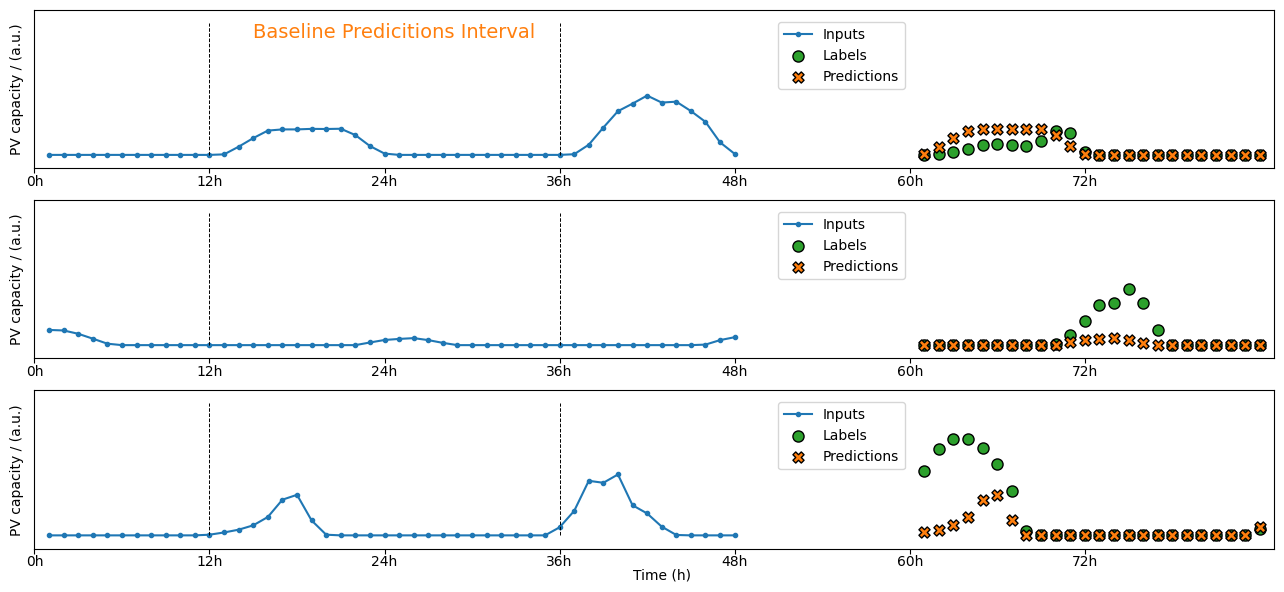

In [34]:
max_n = 3
seq_number = np.random.randint(0, 10000, max_n)

### Plot #######################
########################################
fig, axs = plt.subplots(nrows=max_n, ncols=1, figsize=(16, 7), sharex=True, sharey=True)

for n, ax in enumerate(axs):
    ax.plot(
        sequences_pv.input_indices,
        test_dataset_pv[seq_number[n]][0][:, 4],
        label="Inputs",
        marker=".",
    )  # , zorder=-10, c='b')
    ax.scatter(
        sequences_pv.label_indices,
        test_dataset_pv[seq_number[n]][1][:, 0],
        edgecolors="k",
        label="Labels",
        c="#2ca02c",
        s=64,
    )
    ax.scatter(
        sequences_pv.label_indices,
        test_dataset_pv[seq_number[n]][0][12:-12, 4],
        marker="X",
        edgecolors="k",
        label="Predictions",
        c="#ff7f0e",
        s=64,
    )

    ax.vlines(11, ymin=0, ymax=1, color="k", linewidth=0.7, linestyle="--")
    ax.vlines(35, ymin=0, ymax=1, color="k", linewidth=0.7, linestyle="--")
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(-1, 84)

    # ax.set_axis_off()
    ax.set_yticks([])
    ax.set_ylabel("PV capacity / (a.u.)")

    x_labels = np.arange(sequences_pv.total_window_size, step=12)
    ax.set_xticks([i - 1 for i in x_labels])
    ax.set_xticklabels([])

    for value in x_labels:
        ax.text(x=value - 1, y=-0.2, s=f"{value}h", va="center", ha="center")

    ax.legend(loc=(0.6, 0.5))

plt.text(x=42, y=-0.3, s=f"Time (h)", va="center", ha="center")

text = "Baseline Predicitions Interval"
fig.text(0.35, 0.84, text, ha="center", fontsize=14, c="#ff7f0e")

## 5.3 Prepare the datasets

In [35]:
sequences_pv = SequenceGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=SHIFT,
    number_sequences=10_000,
    train_df=train_df_pv[num_cols_pv],
    val_df=val_df_pv[num_cols_pv],
    test_df=test_df_pv[num_cols_pv],
    label_columns=["electricity"],
)

train_dataset_pv = sequences_pv.train
val_dataset_pv = sequences_pv.val
test_dataset_pv = sequences_pv.test

100%|██████████| 10000/10000 [00:00<00:00, 14787.81it/s]


In [36]:
train_dataset_forecast = SequenceForecastDataset(
    df=train_df_forecast.select_dtypes(include=np.number), label_columns=["electricity"]
)
val_dataset_forecast = SequenceForecastDataset(
    df=val_df_forecast.select_dtypes(include=np.number), label_columns=["electricity"]
)
test_dataset_forecast = SequenceForecastDataset(
    df=test_df_forecast.select_dtypes(include=np.number), label_columns=["electricity"]
)

## 5.4 Dataloader and training functions

In [37]:
def get_dataloaders(
    dataset: Literal["pv", "forecast"],
    batch_size: int = 32,
) -> Tuple[DataLoader, DataLoader, DataLoader, int]:
    """
    Returns:
        train_loader
        val_loader
        test_loader
        n_features
    """

    if dataset == "pv":
        train_dataset = sequences_pv.train
        val_dataset = sequences_pv.val
        test_dataset = sequences_pv.test
        n_features = train_dataset.tensors[0].shape[-1]
    else:
        train_dataset = train_dataset_forecast
        val_dataset = val_dataset_forecast
        test_dataset = test_dataset_forecast
        n_features = train_dataset.example[0].shape[-1]

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    return train_loader, val_loader, test_loader, n_features

In [38]:
def training_one_epoch(
    model: nn.Module,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    loss_fn: nn.Module = nn.MSELoss(),
    optim: torch.optim.Optimizer = torch.optim.Adam,
):
    size = len(train_dataloader.dataset)
    running_loss = 0
    for batch, data in enumerate(train_dataloader):
        X, y = data
        output = model(X)
        loss = loss_fn(output, y)

        optim.zero_grad()
        loss.backward()
        optim.step()
        running_loss += loss.item()
        mae = torch.mean(abs(output - y))

        # if batch % 10 == 9:
        #     loss, current = loss.item(), batch * batch_size + len(X)
        #     print(f"\tloss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    with torch.no_grad():
        outputs = []
        labels = []
        vsize = len(val_dataloader.dataset)
        running_vloss = 0.0

        # In evaluation mode some model specific operations can be omitted
        #  -> eg. dropout layer
        # Switching to evaluation mode, eg. turning off regularisation
        model.eval()
        for j, vdata in enumerate(val_dataloader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            outputs.append(voutputs)
            labels.append(vlabels)
            vloss = loss_fn(voutputs, vlabels)
            vmae = torch.mean(abs(voutputs - vlabels))
            running_vloss += vloss.item()

            # if j % 10 == 9:
            #     vloss, vcurrent = vloss.item(), j * batch_size + len(vinputs)
            #     print(f"\tval loss: {vloss:>7f}  [{vcurrent:>5d}/{vsize:>5d}]")

        model.train(True)

    return loss, vloss, mae, vmae

In [39]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float("inf")

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [40]:
early_stopping = EarlyStopper(patience=5)


def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    epochs: int = 100,
    learning_rate: float = 1e-3,
    batch_size: int = 32,
    early_stopping: EarlyStopper = None,
    patience: int = 5,
) -> Tuple[nn.Module, dict]:
    optim = optimizer(params=model.parameters(), lr=learning_rate)
    history = defaultdict(list)
    for epoch in tqdm(range(epochs)):
        print(f"Epoch {epoch + 1}:")
        model.train()
        loss, vloss, mae, vmae = training_one_epoch(
            model, train_loader, val_loader, loss_fn=loss_fn, optim=optim
        )

        history["loss"].append(loss.detach())
        history["val_loss"].append(vloss)
        history["mae"].append(mae.detach())
        history["val_mae"].append(vmae)

        if early_stopping.early_stop(vloss):
            print(f"Early stopping at epoch {epoch}")
            break
    return model, history

In [41]:
def plot_loss_mae(history):
    # Setting figures
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

    # Create the plots
    ax1.plot(history["loss"])
    ax1.plot(history["val_loss"])
    ax2.plot(history["mae"])
    ax2.plot(history["val_mae"])

    # Set titles and labels
    ax1.set_title("Model loss")
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Epoch")

    ax2.set_title("Mean Absolute Error")
    ax2.set_ylabel("MAE")
    ax2.set_xlabel("Epoch")

    # Set limits for y-axes
    # ax1.set_ylim(ymin=0, ymax=20)
    # ax2.set_ylim(ymin=0, ymax=200)

    # Generate legends
    ax1.legend(["Train", "Validation"], loc="best")
    ax2.legend(["Train", "Validation"], loc="best")

    # Show grids
    ax1.grid(axis="x", linewidth=0.5)
    ax1.grid(axis="y", linewidth=0.5)

    ax2.grid(axis="x", linewidth=0.5)
    ax2.grid(axis="y", linewidth=0.5)

    plt.show()

## 5.4 Simple LSTM and RNN models

In [42]:
class LSTMModel(nn.Module):
    def __init__(self, p: int):
        super(LSTMModel, self).__init__()
        self.n_features = p
        self.lstm = nn.LSTM(p, 24, batch_first=True)
        self.linear = nn.Linear(24, 24)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = F.tanh(x)
        x = self.linear(x[:, -1, :])
        return x.view(len(x), -1, 1)

In [43]:
class RNNModel(nn.Module):
    def __init__(self, p: int):
        super(RNNModel, self).__init__()
        self.n_features = p
        self.lstm = nn.RNN(p, 24, batch_first=True)
        self.linear = nn.Linear(24, 24)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = F.tanh(x)
        x = self.linear(x[:, -1, :])
        return x.view(len(x), -1, 1)

In [44]:
class LSTMModel_2(nn.Module):
    def __init__(self, p: int):
        super(LSTMModel_2, self).__init__()
        self.n_features = p
        self.lstm1 = nn.LSTM(p, 24, batch_first=True)
        self.lstm2 = nn.LSTM(24, 24, batch_first=True)
        self.linear1 = nn.Linear(24, 16)
        self.dropout = nn.Dropout(0.5)
        self.linear2 = nn.Linear(16, 24)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = F.tanh(x)
        x, _ = self.lstm2(x)
        x = F.tanh(x)
        x = self.linear1(x[:, -1, :])
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x.view(len(x), -1, 1)


train_loader, val_loader, test_loader, n_features = get_dataloaders(
    "forecast", batch_size=32
)

summary(LSTMModel_2(n_features), verbose=2, mode="train");

Layer (type:depth-idx)                   Param #
LSTMModel_2                              --
├─LSTM: 1-1                              4,704
│    └─weight_ih_l0                      ├─2,208
│    └─weight_hh_l0                      ├─2,304
│    └─bias_ih_l0                        ├─96
│    └─bias_hh_l0                        └─96
├─LSTM: 1-2                              4,800
│    └─weight_ih_l0                      ├─2,304
│    └─weight_hh_l0                      ├─2,304
│    └─bias_ih_l0                        ├─96
│    └─bias_hh_l0                        └─96
├─Linear: 1-3                            400
│    └─weight                            ├─384
│    └─bias                              └─16
├─Dropout: 1-4                           --
├─Linear: 1-5                            408
│    └─weight                            ├─384
│    └─bias                              └─24
Total params: 10,312
Trainable params: 10,312
Non-trainable params: 0


In [45]:
class LSTMModel_3(nn.Module):
    def __init__(self, p: int):
        super().__init__()
        self.n_features = p
        self.lstm1 = nn.LSTM(p, 48, batch_first=True)
        self.lstm2 = nn.LSTM(48, 24, batch_first=False)
        self.linear1 = nn.Linear(24, 32)
        self.dropout = nn.Dropout(0.5)
        self.linear2 = nn.Linear(32, 24)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = F.tanh(x)
        x, _ = self.lstm2(x)
        x = F.tanh(x)
        x = self.linear1(x[:, -1, :])
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x.view(len(x), -1, 1)

summary(LSTMModel_3(n_features), verbose=2, mode="train");

Layer (type:depth-idx)                   Param #
LSTMModel_3                              --
├─LSTM: 1-1                              14,016
│    └─weight_ih_l0                      ├─4,416
│    └─weight_hh_l0                      ├─9,216
│    └─bias_ih_l0                        ├─192
│    └─bias_hh_l0                        └─192
├─LSTM: 1-2                              7,104
│    └─weight_ih_l0                      ├─4,608
│    └─weight_hh_l0                      ├─2,304
│    └─bias_ih_l0                        ├─96
│    └─bias_hh_l0                        └─96
├─Linear: 1-3                            800
│    └─weight                            ├─768
│    └─bias                              └─32
├─Dropout: 1-4                           --
├─Linear: 1-5                            792
│    └─weight                            ├─768
│    └─bias                              └─24
Total params: 22,712
Trainable params: 22,712
Non-trainable params: 0


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:


  2%|▏         | 1/50 [00:06<05:19,  6.53s/it]

Epoch 2:


  4%|▍         | 2/50 [00:12<05:06,  6.38s/it]

Epoch 3:


  6%|▌         | 3/50 [00:19<05:01,  6.41s/it]

Epoch 4:


  8%|▊         | 4/50 [00:25<04:49,  6.29s/it]

Epoch 5:


 10%|█         | 5/50 [00:30<04:29,  5.99s/it]

Epoch 6:


 12%|█▏        | 6/50 [00:36<04:22,  5.97s/it]

Epoch 7:


 14%|█▍        | 7/50 [00:42<04:09,  5.80s/it]

Epoch 8:


 16%|█▌        | 8/50 [00:47<03:55,  5.62s/it]

Epoch 9:


 18%|█▊        | 9/50 [00:52<03:47,  5.54s/it]

Epoch 10:


 20%|██        | 10/50 [00:58<03:44,  5.60s/it]

Epoch 11:


 22%|██▏       | 11/50 [01:04<03:38,  5.60s/it]

Epoch 12:


 22%|██▏       | 11/50 [01:10<04:11,  6.44s/it]

Early stopping at epoch 11


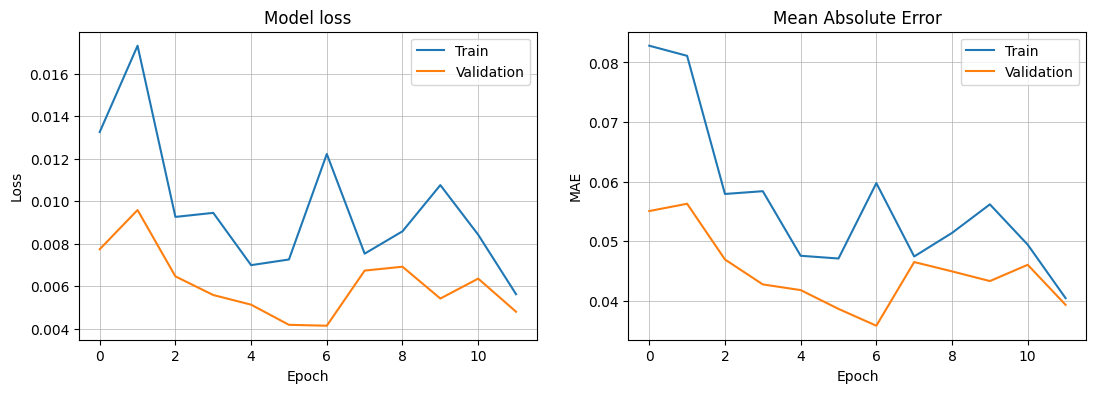

Regression Metrics: {'mse': tensor(0.0071), 'rmse': tensor(0.0844), 'mae': tensor(0.0443), 'r2': tensor(0.9373)}


In [46]:
train_loader, val_loader, test_loader, n_features = get_dataloaders("forecast", batch_size=32)

model = LSTMModel_3(p=n_features)
loss_fn = nn.MSELoss()
optimizers = [torch.optim.Adam, torch.optim.SGD, torch.optim.RMSprop]
optim = optimizers[0]
early_stopping = EarlyStopper(patience=5)

model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=torch.optim.RMSprop,
    epochs=50,
    learning_rate=1e-3,
    batch_size=16,
    early_stopping=early_stopping,
    patience=5,
)

# plot theloss eand evaluation curves
plot_loss_mae(history)


metrics = compute_regression_metrics(model, test_loader)

val_mae = np.min(history["val_mae"])
print("Regression Metrics:", metrics)

# 6. Evaluate model

In [47]:
model.eval()
compute_regression_metrics(model, test_loader_pv)

RuntimeError: input.size(-1) must be equal to input_size. Expected 23, got 5

# 7. Make a prediction

Let's make a prediction with our model. <br>
We take as an input the day we want to predict the PV production

In [ ]:
input_pred = "2022-07-06"

# Compute the necessary datetime objects for the BQ querying
dt_day_ahead_begin = pd.to_datetime(input_pred, utc=True)
dt_day_ahead_end = dt_day_ahead_begin + np.timedelta64(23, "h")

dt_noon_weather_forecast = dt_day_ahead_begin - np.timedelta64(12, "h")

dt_pv_data_begin = dt_noon_weather_forecast - np.timedelta64(47, "h")
dt_pv_data_end = dt_noon_weather_forecast

Query the data from BigQuery directly.<br>
This way we work in real-life scenario: we have a raw weather forecast for the day ahead

Set-up the BQ query

In [ ]:
GCP_PROJECT = os.environ.get("GCP_PROJECT")
BQ_DATASET = os.environ.get("BQ_DATASET")


def query_bq_data(
    gcp_project: str,
    query: str,
) -> pd.DataFrame:
    """
    Retrieve `query` data from BigQuery
    """

    print(Fore.BLUE + "\nLoad data from BigQuery server..." + Style.RESET_ALL)
    client = bigquery.Client(project=gcp_project)
    query_job = client.query(query)
    result = query_job.result()
    df = result.to_dataframe()

    print(f"✅ Data loaded, with shape {df.shape}")

    return df

In [ ]:
# Query raw PV data from BUCKET BigQuery
query_pv = f"""
    SELECT *
    FROM {GCP_PROJECT}.{BQ_DATASET}.raw_pv
    WHERE _0 BETWEEN {int(dt_pv_data_begin.timestamp()) * 1000}
                AND {int(dt_pv_data_end.timestamp()) * 1000}
    ORDER BY _0
"""

# Retrieve data from BigQuery
data_pv_query = query_bq_data(query=query_pv, gcp_project=GCP_PROJECT)

# Query raw historical weather forecast data from BigQuery
query_forecast = f"""
    SELECT *
    FROM {GCP_PROJECT}.{BQ_DATASET}.raw_weather_forecast
    WHERE forecast_dt_unixtime = {int(dt_noon_weather_forecast.timestamp())}
    ORDER BY forecast_dt_unixtime, slice_dt_unixtime
"""

data_forecast_query = query_bq_data(query=query_forecast, gcp_project=GCP_PROJECT)

# fix issue with column name in BigQuery (the issue is just in the notebook)
try:
    assert data_forecast_query.shape[1] == forecast_data.shape[1]
    data_forecast_query.columns = forecast_data.columns
except AssertionError as e:
    print(e)

Clean and preprocess the PV data 

In [ ]:
data_pv_query["local_time"] = pd.to_datetime(data_pv_query["local_time"], utc=True)

# Clean data for the first 24h only
data_pv_processed = preprocess_pv.transform(data_pv_query)

Clean and preprocess the Weather forecast data 

In [ ]:
# Clean data
data_forecast_clean = clean_forecast_data(data_forecast_query)

data_forecast_processed = forecast_transformer.transform(data_forecast_clean)

In [ ]:
DATASET = "pv"  # "forecast" or "pv"

if DATASET == "pv":
    X = data_pv_processed.select_dtypes(include=np.number)
else:
    X = data_forecast_processed.select_dtypes(include=np.number)

X = np.expand_dims(X.values, axis=0)
X_tensor = torch.tensor(X, dtype=torch.float32)
X.shape, model

In [ ]:
model.eval()

y_pred = model.forward(X_tensor)
y_pred_df = pd.DataFrame(y_pred.detach().numpy()[0], columns=["pred"])
y_pred_df["utc_time"] = data_forecast_clean["prediction_utc_time"]
y_pred_df

In [ ]:
# Cut-off predictions that are negative or bigger than max capacity
def cutoff_func(x: float, max_capacity: float = 0.9) -> float:
    """
    Cut off the prediction to be between 0 and max_capacity
    """
    return np.minimum(x, max_capacity) * (x > 0)


y_pred_df["pred"] = y_pred_df["pred"].apply(cutoff_func)
y_pred_df

If you start TensorBoard at the command line and open it in a new browser tab (usually at [localhost:6006](localhost:6006)), you should see the image grid under the IMAGES tab.

## Graphing Scalars to Visualize Training

TensorBoard is useful for tracking the progress and efficacy of your training. Below, we'll run a training loop, track some metrics, and save the data for TensorBoard's consumption.

Let's define a model to categorize our image tiles, and an optimizer and loss function for training:

In [ ]:
# from torch.utils.tensorboard import SummaryWriter

# # Default log_dir argument is "runs" - but it's good to be specific
# # torch.utils.tensorboard.SummaryWriter is imported above
# writer = SummaryWriter()
# # writer.close()

# # Write image data to TensorBoard log dir
# # writer.add_image('Four Fashion-MNIST Images', img_grid)
# # writer.flush()

# # To view, start TensorBoard on the command line with:
# #   tensorboard --logdir=runs
# # ...and open a browser tab to http://localhost:6006/

In [ ]:
# ############# Data ##############
# dataset = 'forecast'  # ['pv', 'forecast']

# ########## Parameters #########
# batch_size = 32
# learning_rate = 1e-3
# epochs = 10


# if dataset == 'pv':
#     train_dataset = train_dataset_pv
#     test_dataset = test_dataset_pv
#     n_features = train_dataset_pv.tensors[0].shape[-1]
# else:
#     train_dataset = train_dataset_forecast
#     test_dataset = test_dataset_forecast
#     n_features = train_dataset.example[0].shape[-1]

# train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle= True)
# test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle= True)

# model = LSTMModel(p = n_features)
# loss_fn = nn.MSELoss()
# optim = torch.optim.Adam(params= model.parameters(), lr= learning_rate)

# print(len(val_loader_forecast))
# for epoch in range(epochs):  # loop over the dataset multiple times
#     running_loss = 0.0

#     for i, data in enumerate(train_loader_forecast, 0):
#         # basic training loop
#         inputs, labels = data
#         optim.zero_grad()
#         outputs = model(inputs)
#         loss = loss_fn(outputs, labels)
#         loss.backward()
#         optim.step()

#         running_loss += loss.item()
#         if i % 8 == 7:    # Every 1000 mini-batches...
#             print('Batch {}'.format(i + 1))
#             # Check against the validation set
#             running_vloss = 0.0

#             # In evaluation mode some model specific operations can be omitted eg. dropout layer
#             model.train(False) # Switching to evaluation mode, eg. turning off regularisation
#             for j, vdata in enumerate(val_loader_forecast, 0):
#                 vinputs, vlabels = vdata
#                 voutputs = model(vinputs)
#                 vloss = loss_fn(voutputs, vlabels)
#                 running_vloss += vloss.item()
#             model.train(True) # Switching back to training mode, eg. turning on regularisation

#             avg_loss = running_loss / 1000
#             avg_vloss = running_vloss / len(val_loader_forecast)

#             # Log the running loss averaged per batch
#             writer.add_scalars('Training vs. Validation Loss',
#                             { 'Training' : avg_loss, 'Validation' : avg_vloss },
#                             epoch * len(train_loader_forecast) + i)

#             running_loss = 0.0
# print('Finished Training')

# writer.flush()

Switch to your open TensorBoard and have a look at the SCALARS tab.

## Visualizing Your Model
TensorBoard can also be used to examine the data flow within your model. To do this, call the `add_graph()` method with a model and sample input. When you open 

In [ ]:
# # Again, grab a single mini-batch of images
# dataiter = iter(train_loader_forecast)
# inputs, labels = next(dataiter)

# # add_graph() will trace the sample input through your model,
# # and render it as a graph.
# writer.add_graph(model, inputs)
# writer.flush()
# writer.close

In [ ]:
# baseline_pv, baseline_forecast